In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
    
data = pd.read_excel('data/all_features_v2_dataset_no_header.xlsx')

In [2]:
X_org = data.iloc[:,0:9]  # features
Y_org = data.iloc[:,-1]    # label column

In [3]:
Y = Y_org.to_numpy()
X = X_org.to_numpy()
data = scale(X)

n_samples, n_features = data.shape
n_digits = len(np.unique(Y))
labels = Y


In [4]:
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

sample_size = 300

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    cluster_label_freqs = []
    cluster_instance_counts = []
    for ix in range(0, 10):
        cluster_label_freqs.append({})
        cluster_instance_counts.append(0)
        
    for label, cluster in zip(labels, estimator.labels_):
        cluster_instance_counts[cluster] += 1
        try:
            cluster_label_freqs[cluster][label] += 1
        except KeyError:
            cluster_label_freqs[cluster][label] = 1
            
    for lists in cluster_label_freqs:
        pie_labels = list(lists.keys())
        pie_sizes = list(lists.values())
        
        fig1, ax1 = plt.subplots()
        ax1.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.show()
    
    
    print(cluster_instance_counts)
    print(cluster_label_freqs)
    
    

n_digits: 9, 	 n_samples 93274, 	 n_features 9
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


PCA-based	1.91s	243488	0.163	0.124	0.141	0.103	0.141	0.154


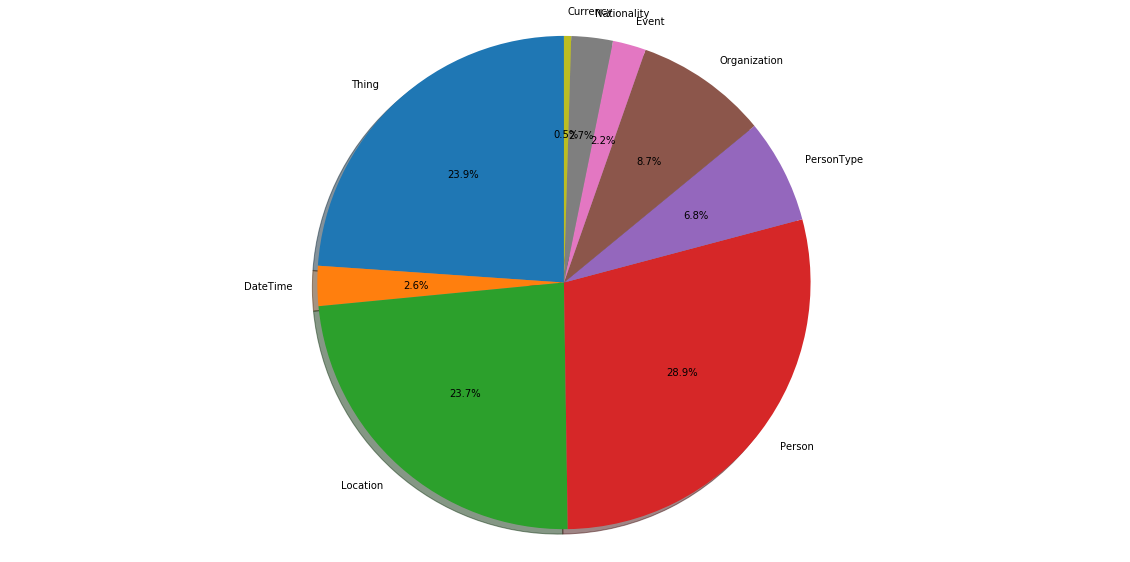

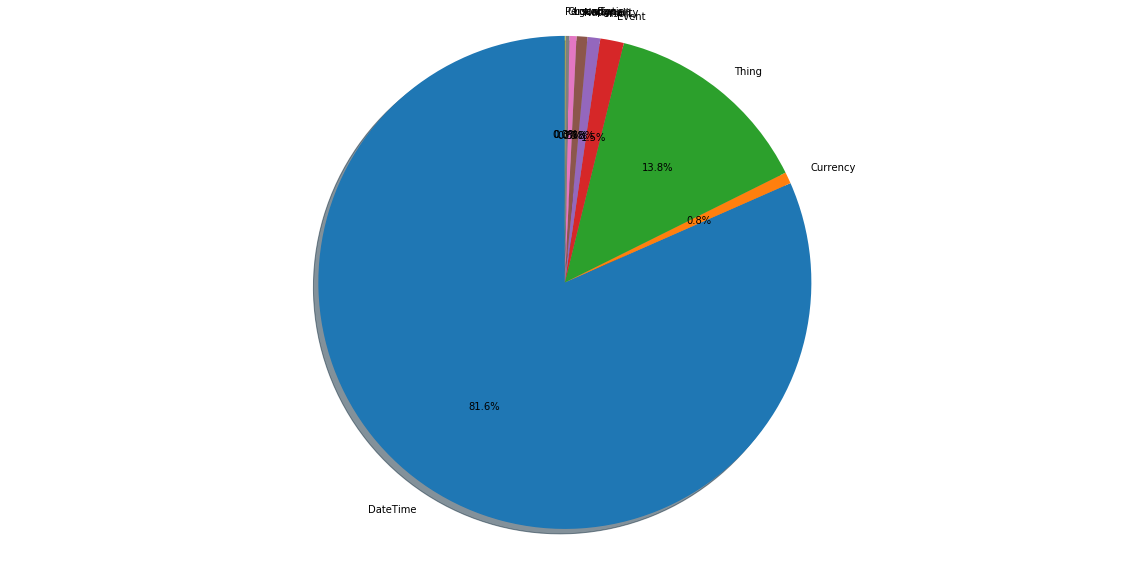

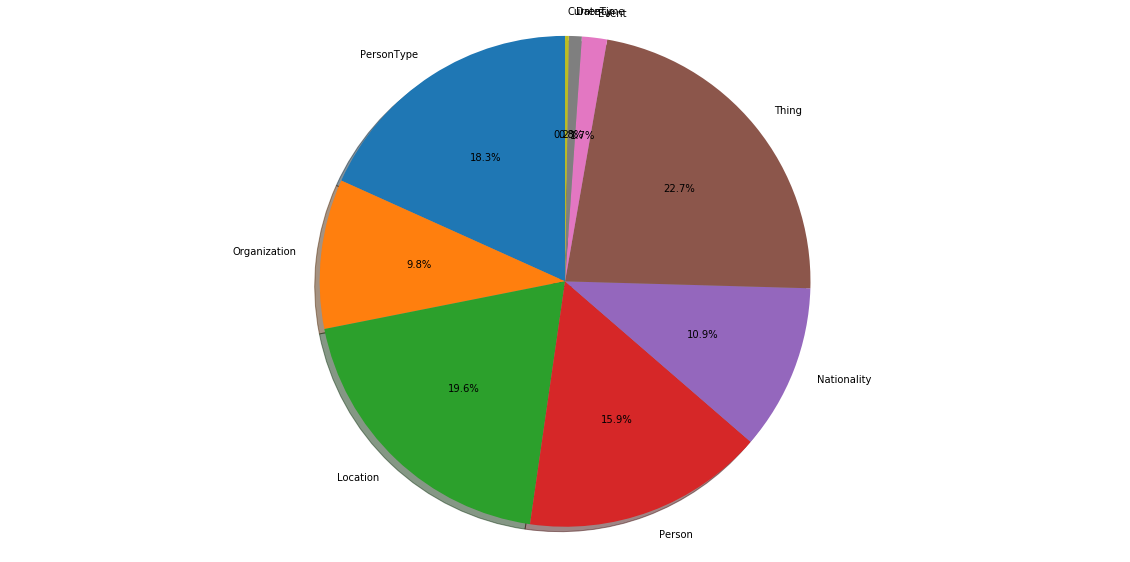

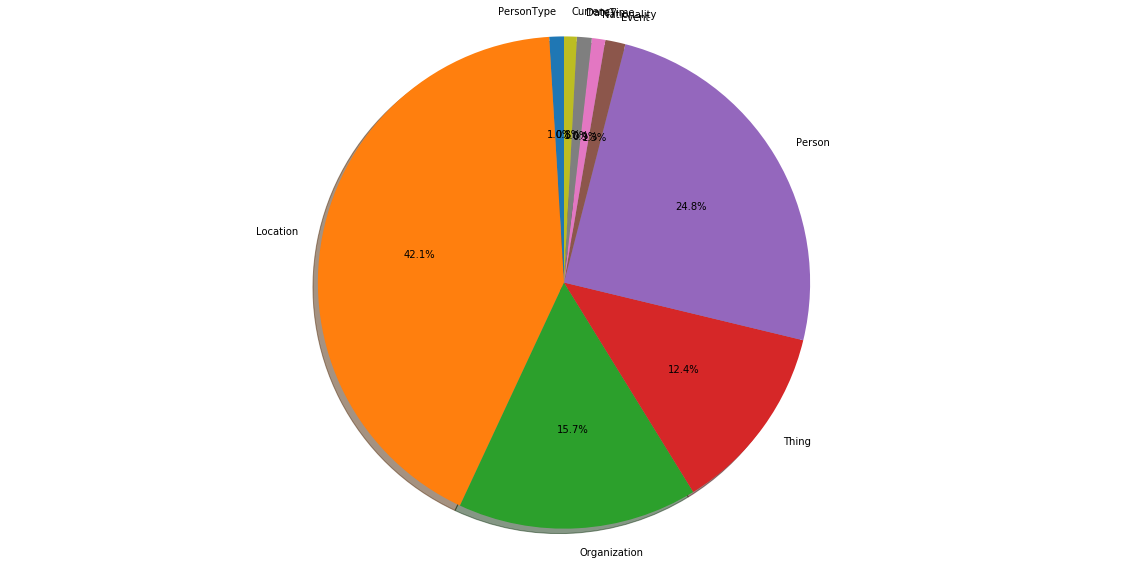

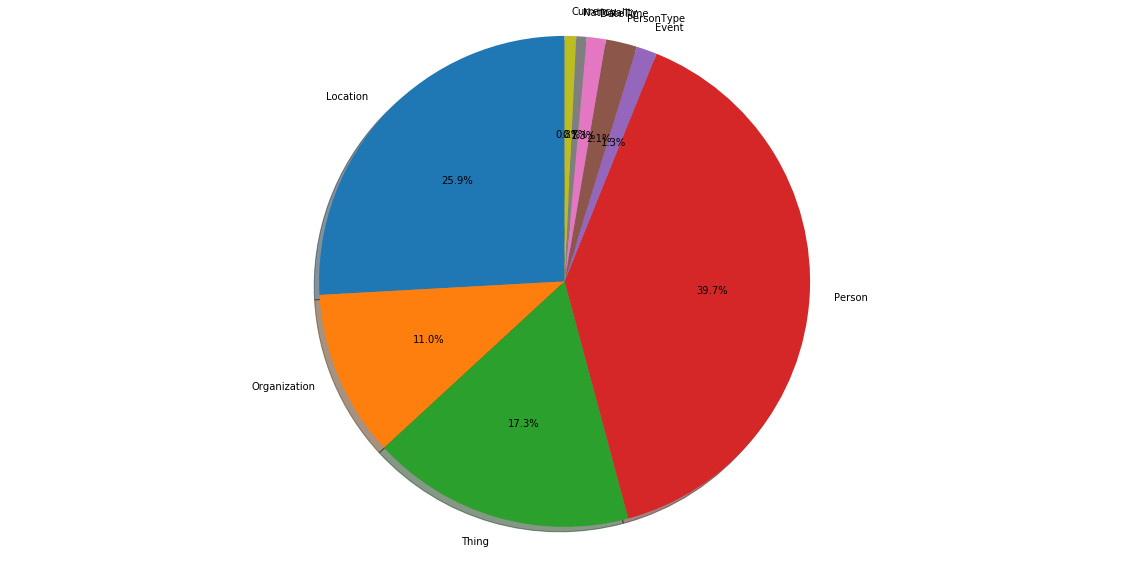

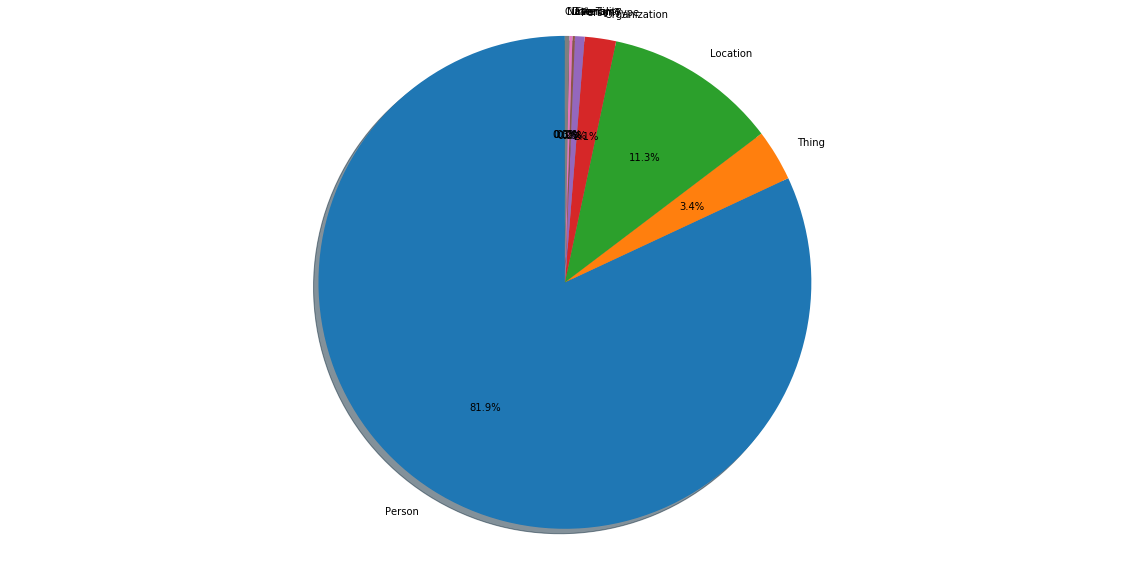

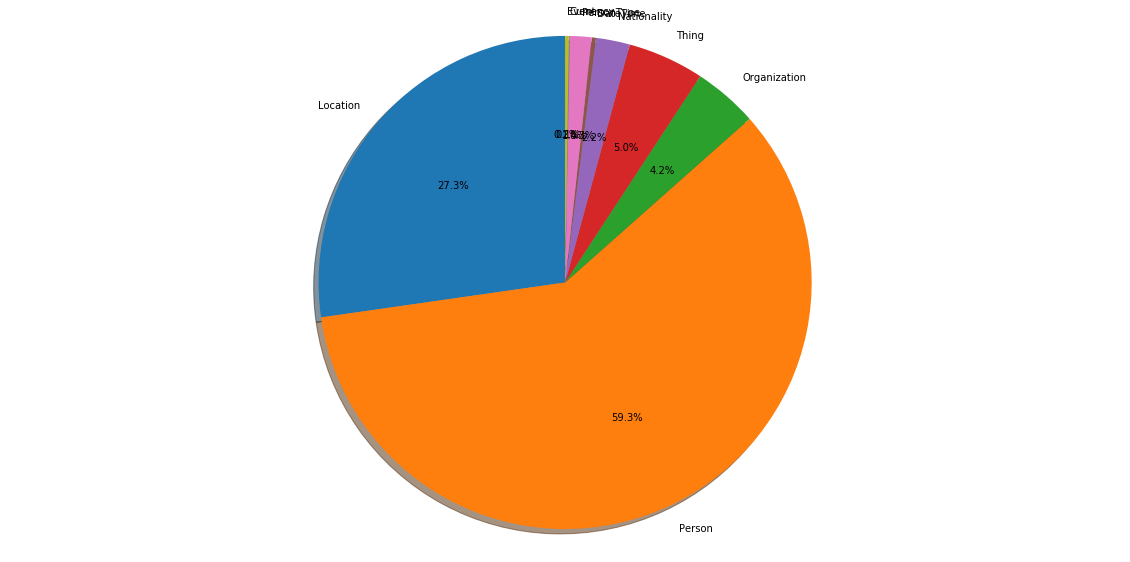

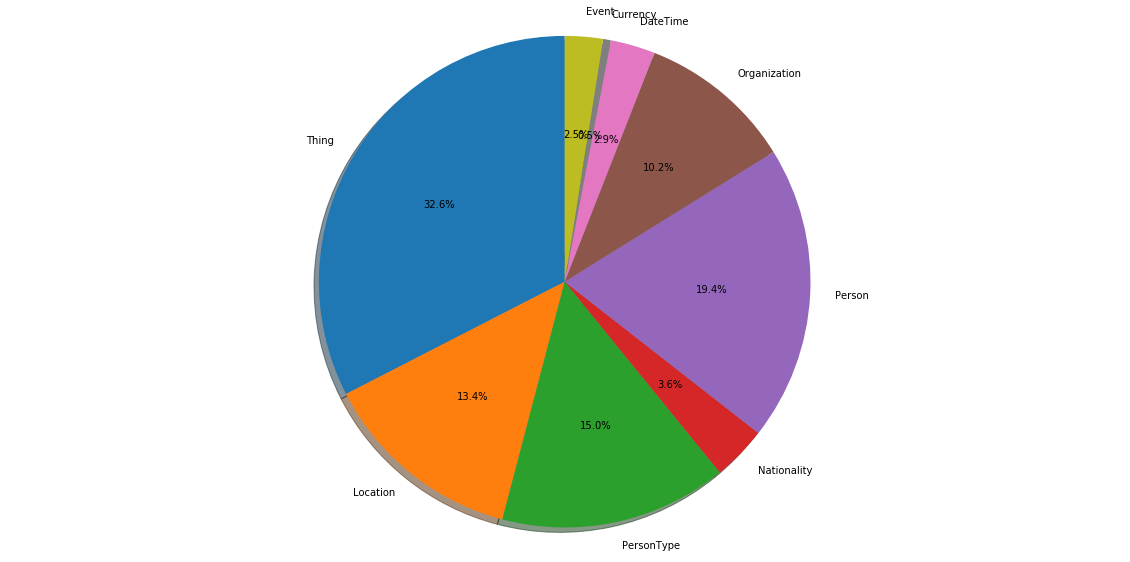

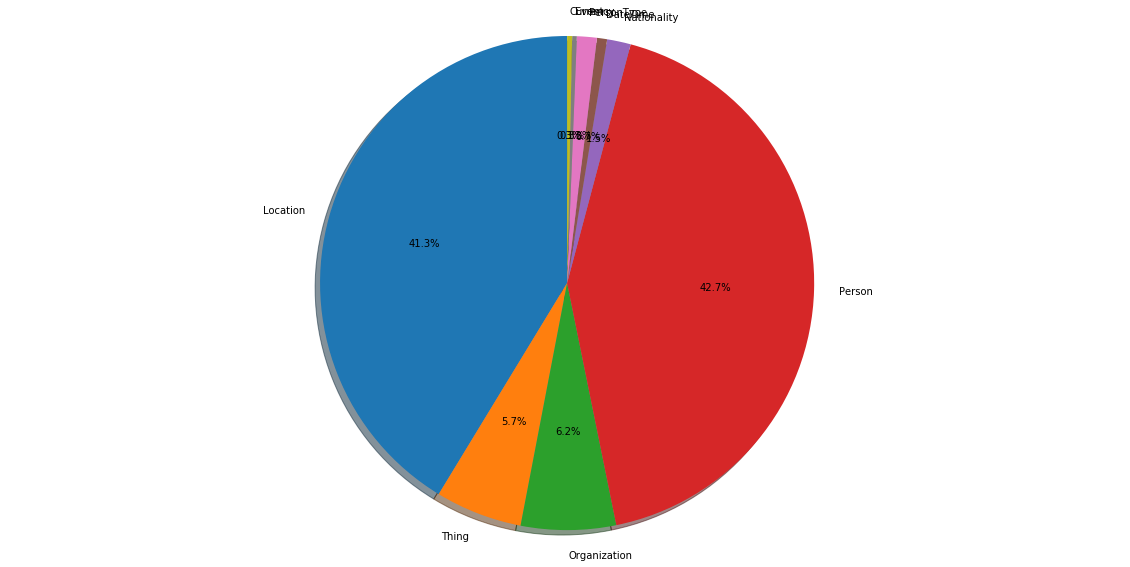

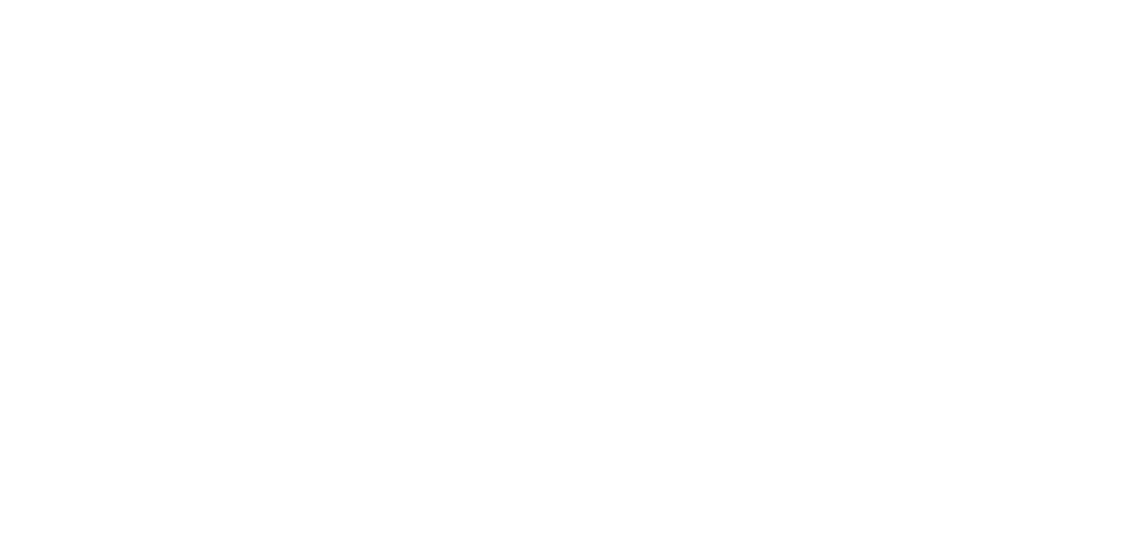

[4044, 2391, 9422, 13383, 12597, 16407, 16758, 9677, 8595, 0]
[{'Thing': 967, 'DateTime': 106, 'Location': 959, 'Person': 1168, 'PersonType': 276, 'Organization': 351, 'Event': 88, 'Nationality': 110, 'Currency': 19}, {'DateTime': 1951, 'Currency': 18, 'Thing': 330, 'Event': 37, 'Person': 20, 'Nationality': 17, 'Location': 11, 'Organization': 6, 'PersonType': 1}, {'PersonType': 1721, 'Organization': 928, 'Location': 1847, 'Person': 1501, 'Nationality': 1027, 'Thing': 2139, 'Event': 156, 'DateTime': 80, 'Currency': 23}, {'PersonType': 129, 'Location': 5633, 'Organization': 2107, 'Thing': 1664, 'Person': 3313, 'Event': 177, 'Nationality': 118, 'DateTime': 130, 'Currency': 112}, {'Location': 3260, 'Organization': 1383, 'Thing': 2182, 'Person': 5003, 'Event': 170, 'PersonType': 259, 'DateTime': 159, 'Nationality': 86, 'Currency': 95}, {'Person': 13445, 'Thing': 553, 'Location': 1862, 'Organization': 337, 'PersonType': 103, 'Event': 27, 'DateTime': 33, 'Nationality': 46, 'Currency': 1}, {'L

In [6]:
plt.rcParams["figure.figsize"] = (20,10)
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)

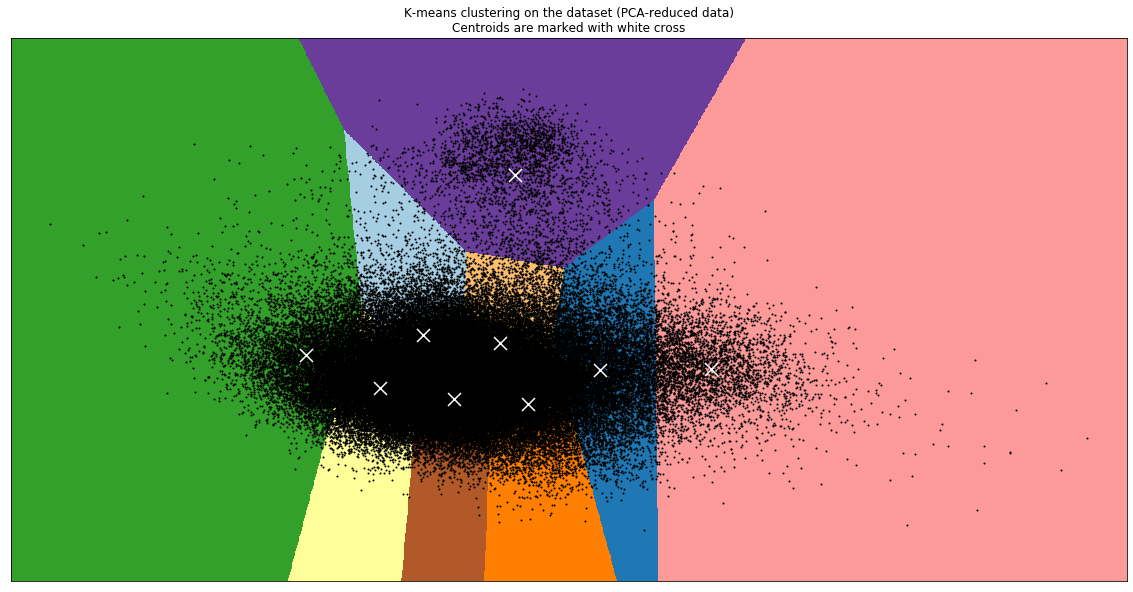

In [7]:
plt.rcParams["figure.figsize"] = (20,10)
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


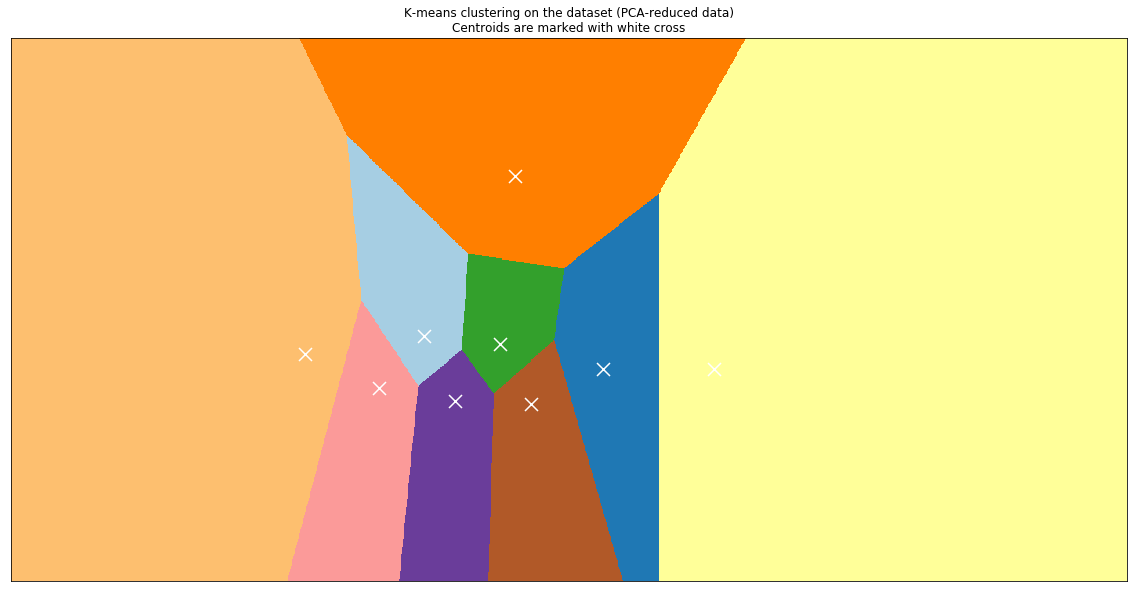

In [8]:
plt.rcParams["figure.figsize"] = (20,10)
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [11]:
print(kmeans.cluster_centers_)

[[-1.12781919  0.62725662]
 [ 3.4356893  -0.01104187]
 [ 0.81646691  0.46407729]
 [-2.27385005 -0.37197451]
 [-4.15451533  0.27992553]
 [ 1.18834289  3.73590794]
 [-0.33297615 -0.62331342]
 [ 6.28373396 -0.01329645]
 [ 1.60654754 -0.69700817]]
